# PyTorch Modules

In [1]:
import  torch
import matplotlib.pyplot as plt
from torch import nn

## torch.nn.functional

在 `torch.nn.functional` 这个库里有许多函数可以让我们直接调用，避免重复造轮子：

- `torch.nn.functional.linear`
    - receives:    
        - X: (batch_size, in_dimensions)
        - W: (out_dimensions, in_dimensions)
        - b: (out_dimensions,) default None
    - returns:
        - output: (batch_size, out_dimensions) 

- `torch.nn.functional.relu`
    - receives:
        - X
    - returns:
        - X_after_relu

- `torch.nn.functional.conv2d`
    - receives:
        - X: (batch_size, in_channels, H, W)
        - W: (out_channels, in_channels, kH, kW)
        - b: (out_channels,) default None
        - stride: default 1   
        - padding: default 0 
    - returns:   
        output: (batch_size, out_channels, (H - kH + 2P) // S + 1, (W - kW + 2P) // S + 1)

- `torch.nn.functional.pad`
    - receives:
        - X: 
        - (left, right, up, down): padding numbers
    - returns:
        - X_padded

- `torch.nn.functional.cross_entropy`
    - receives:
        - scores: (batch_size, dimensions)
        - y: (batch_size,)
    - returns:
        - loss: scalar   
                
## torch.nn.init

在 `torch.nn.init` 这个库里有许多用于初始化的函数：

- `torch.nn.init.kaiming_normal_`
    - receives:
        - `torch.empty`: corresponding shape of W
        - `nonelinearity`: 'relu', 'leaky_relu', ...
    - returns:
        - W: kaming_nromal_ W
                
- `torch.nn.init.zero_`
    - receives:
        - `torch.empty`: corresponding shape of b
    - returns: 
        - b: all neurons set to zero.

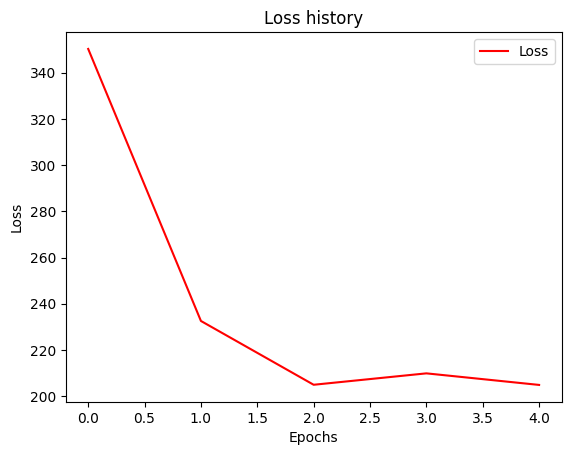

In [2]:
"""
# Conv -> ReLU -> Conv -> ReLU -> Flatten -> Linear -> ReLU -> Linear -> Softmax

Conv1: 8 filters, kernel size of 3x3, stride of 1, padding of 1
ReLU: ...
Conv2: 16 filters, kernel size of 3x3, stride of 1, padding of 1
ReLU: ...
Flatten: ...
Linear1: out dimension of 1000, in dimension of 16 * 32 * 32
Linear2: out dimension of 10, in dimension of 1000
Softmax: ...
"""

# generate training samples
X = torch.randint(0, 256, (64, 3, 32, 32), dtype=torch.float, generator=torch.Generator().manual_seed(42))
y = torch.randint(0, 10, (64,), generator=torch.Generator().manual_seed(42))

# initialize parameters
convW1 = torch.nn.init.kaiming_normal_(torch.empty(8, 3, 3, 3, requires_grad=True, dtype=torch.float))
convb1 = torch.nn.init.zeros_(torch.empty(8, requires_grad=True, dtype=torch.float))
convW2 = torch.nn.init.kaiming_normal_(torch.empty(16, 8, 3, 3, requires_grad=True, dtype=torch.float))
convb2 = torch.nn.init.zeros_(torch.empty(16, requires_grad=True, dtype=torch.float))
linarW1 = torch.nn.init.kaiming_normal_(torch.empty(1000, 16 * 32 * 32, requires_grad=True, dtype=torch.float))
linarb1 = torch.nn.init.zeros_(torch.empty(1000, requires_grad=True, dtype=torch.float))
linarW2 = torch.nn.init.kaiming_normal_(torch.empty(10, 1000, requires_grad=True, dtype=torch.float))
linarb2 = torch.nn.init.zeros_(torch.empty(10, requires_grad=True, dtype=torch.float))

loss_history = []
epochs = range(5)

for epoch in epochs:
    feature_map = torch.nn.functional.conv2d(X, convW1, convb1, stride=1, padding=1)
    feature_map = torch.nn.functional.relu(feature_map)
    
    feature_map = torch.nn.functional.conv2d(feature_map, convW2, convb2, stride=1, padding=1)
    feature_map = torch.nn.functional.relu(feature_map)
    feature_map = feature_map.view(feature_map.shape[0], -1)
    
    feature_map = torch.nn.functional.linear(feature_map, linarW1, linarb1)
    feature_map = torch.nn.functional.relu(feature_map)
    scores = torch.nn.functional.linear(feature_map, linarW2, linarb2)
    
    loss = torch.nn.functional.cross_entropy(scores, y)
    loss_history.append(loss.item())
    
    loss.backward()
    
    with torch.no_grad():
        convW1 -= 1e-5 * convW1.grad
        convb1 -= 1e-5 * convb1.grad
        convW2 -= 1e-5 * convW2.grad
        convb2 -= 1e-5 * convb2.grad
        linarW1 -= 1e-5 * linarW1.grad
        linarb1 -= 1e-5 * linarb1.grad
        linarW2 -= 1e-5 * linarW2.grad
        linarb2 -= 1e-5 * linarb2.grad
        
        convW1.grad.zero_()
        convb1.grad.zero_()
        convW2.grad.zero_()
        convb2.grad.zero_()
        linarW1.grad.zero_()
        linarb1.grad.zero_()
        linarW2.grad.zero_()
        linarb2.grad.zero_()

plt.figure()        
plt.plot(epochs, loss_history, color='red', label='Loss')
plt.legend()
plt.title('Loss history')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## torch.nn.Module

在以上的方法，我们需要自己手动创建一个个参数，这很麻烦，我们可以直接使用 `torch.nn.Module` 的子类来创建一个自己的网络同时避免手动创建大量参数。使用 `torch.nn.Module` 其实只用实现两个方法就行了：

- `__init__`: 在这里创建好模型需要的层，比如 `torch.nn.Conv2d`, `torch.nn.Linear` 等等，它们本身也是 `torch.nn.Modlue` 的子类。然后将层的可学习参数进行初始化 (如果该层有可学习参数的话) 。
- `forward`: 在这里使用在 `__init__` 中定义的层，决定如何向前传播. **千万不要在 `forward` 中创建新的有可学习参数的层，否则会出错，所有有可学习参数的层都必须创建在 `__init__` 中；但是可以在 `forward` 中创建新的没有可学习参数的层**。

常见的 `torch.nn.Module`:

- `torch.nn.Conv2d`
- `torch.nn.BatchNorm2d`
- `torch.nn.ReLU`
- `torch.nn.AvgPool2d`
- `torch.nn.MaxPool2d`
- `torch.nn.Flatten`
- `torch.nn.Linear`
- `torch.nn.BatchNorm1d`
- `torch.nn.Identity`

在调用创建好的 Module 正向传播时，直接 `Module(X)` 。 

In [3]:
class ZhihangNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # NOTE: 创建需要的层
        self.conv1 = torch.nn.Conv2d(3, 8, kernel_size=(3, 3), padding=(1, 1), stride=1)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=(3, 3), padding=(1, 1), stride=1)
        self.relu2 = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(16 * 32 * 32, 1000) 
        self.relu3 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(1000, 10)

        # NOTE: 直接将层的可学习参数传入初始化函数中
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
        nn.init.kaiming_normal_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        nn.init.kaiming_normal_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)

    def forward(self, X):
        # NOTE: 在正向传播的时候将所有的模型串联起来
        feature_map = self.conv1(X)
        feature_map = self.relu1(feature_map)
        feature_map = self.conv2(feature_map)
        feature_map = self.relu2(feature_map)
        feature_map = self.flatten(feature_map)
        feature_map = self.linear1(feature_map)
        feature_map = self.relu3(feature_map)
        scores = self.linear2(feature_map)
        return scores

## torch.optim

`torch.optim` 模块提供了一系列的优化方法，比如 SGD, SGD + Momentum, Adagrad, RMSProp, Adam 等等。

- `torch.optim.SGD`:
    - receives:
        - `model.parameters()`: 模型的参数
        - `lr`: 学习率 
        - `momentum`: 动量参数，一般设置为0.9，默认为0
    - returns:  
        - 优化方法 SGD

- `torch.optim.Adam`:
    - receives:
        - `model.paramters()`: 模型的参数
        - `lr`: 学习率
        - `betas`: (beta1, beta2)  
    - returns: 
        - 优化方法 Adam

每次调用 `backward` 函数之后梯度会累加，所以在调用 `backward` 之前，记得使用 `optimizer.zero_grad` 将上一轮计算的梯度进行清零，然后再调用 `backward` 计算梯度，使用 `opimizer.step` 更新梯度。

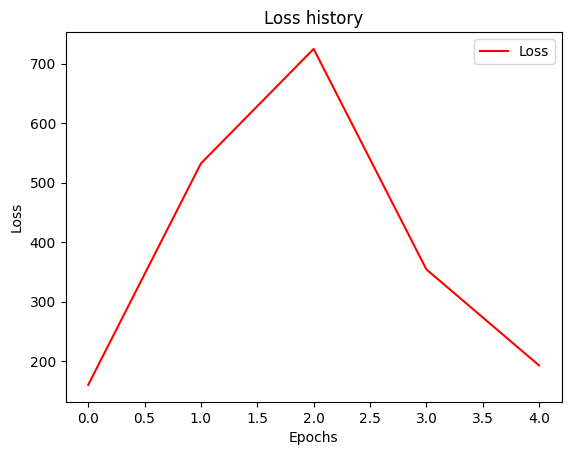

In [20]:
# 创建一个 ZhihangNet
model = ZhihangNet()

# 创建一个优化方法
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

loss_history = []

for epoch in epochs:
    scores = model(X)
    loss = torch.nn.functional.cross_entropy(scores, y)
    loss_history.append(loss.item())
    optimizer.zero_grad() # NOTE: 清零上一轮的梯度
    loss.backward() # NOTE: 计算这一轮的梯度
    optimizer.step() # NOTE: 使用这一轮的梯度更新参数
    
plt.figure()        
plt.plot(epochs, loss_history, color='red', label='Loss')
plt.legend()
plt.title('Loss history')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## torch.nn.Sequential

想要自己堆叠网络，有比自定义一个 `torch.nn.Module` 更快的方式，就是使用 `torch.nn.Sequential` ，虽然使用这种方法在某种程度上会损失一定的灵活性 (比如似乎无法用这种方法构造出一个ResNet)。

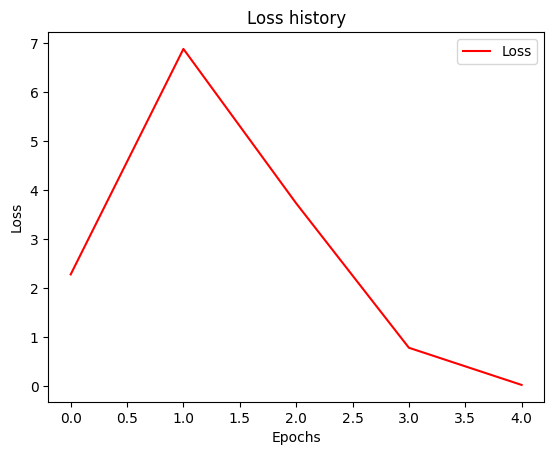

In [23]:
# 创建一个 YiNet，结构和 ZhihangNet 一摸一样
YiNet = torch.nn.Sequential(
    torch.nn.Conv2d(3, 8, kernel_size=(3, 3), padding=(1, 1), stride=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(8, 16, kernel_size=(3, 3), padding=(1, 1), stride=1),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(16 * 32 * 32, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 10)
)

# 创建优化策略 
optimizer = torch.optim.Adam(YiNet.parameters(), lr=1e-4, betas=(0.9, 0.999))

loss_history = []

for epoch in epochs:
    scores = YiNet(X)
    loss = torch.nn.functional.multi_margin_loss(scores, y)
    loss_history.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.figure()        
plt.plot(epochs, loss_history, color='red', label='Loss')
plt.legend()
plt.title('Loss history')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## torch.nn.Parameter

可以用创建 `torch.nn.Module` 而只创建参数 `torch.nn.Parameter`。

In [3]:
class RNN(torch.nn.Module):
    def __init__(self, input_dimensions, hidden_dimensions, output_dimensions, max_length, dtype=torch.float, device='cpu'):
        super().__init__()

        self.max_length = max_length

        # for hidden state part
        self.Wx = torch.nn.Parameter(torch.empty(input_dimensions, hidden_dimensions, dtype=dtype, device=device))
        self.Wh = torch.nn.Parameter(torch.empty(hidden_dimensions, hidden_dimensions, dtype=dtype, device=device))
        self.b = torch.nn.Parameter(torch.zeros(hidden_dimensions, dtype=dtype, device=device))

        torch.nn.init.kaiming_normal_(self.Wx, nonlinearity='tanh')
        torch.nn.init.kaiming_normal_(self.Wh, nonlinearity='tanh')
        torch.nn.init.zeros_(self.b)

        # convert hidden state into output
        self.fc = torch.nn.Linear(hidden_dimensions, output_dimensions, dtype=dtype, device=device)

    def train_forward(self, X, h0=None):
        """

        :param X: (N, T, D), D dimensions, each sample with T sequences and N samples
        :param h0: (N, H), initial hidden state
        :return: outputs
        """
        N, T, D = X.shape
        H = self.Wh.shape[0]

        # initialize h0 if it's not initialized
        if h0 is None:
            h0 = torch.zeros(N, H, dtype=X.dtype, device=X.device)

        h_next = h0
        outputs = []

        # forward pass
        for t in range(T):
            h_next = X[:, t, :] @ self.Wx + h_next @ self.Wh + self.b
            h_next = h_next.tanh()

            out = self.fc(h_next)  # (N, output_dim)
            outputs.append(out)

        # convert Python list to PyTorch tensor
        outputs = torch.stack(outputs, dim=1)  # (N, T, output_dim)

        return outputs

    def test_forward(self, h0):
        """

        :param h0: (N, H), initial hidden state
        :return: output tokens
        """
        N = h0.shape[0]
        D = self.Wx.shape[0]

        start_token = torch.ones(N, D, dtype=h0.dtype, device=h0.device)
        next_token = start_token
        h_next = h0

        tokens = []

        for i in range(self.max_length):
            h_next = next_token @ self.Wx + h_next @ self.Wh + self.b
            h_next = h_next.tanh()

            next_token = self.fc(h_next)  # (N, out_dim)
            tokens.append(next_token)

        # convert Python list to PyTorch tensor
        tokens = torch.stack(tokens, dim=1)  # (N, max_length, out_dim)

        return tokens